# PHASE 2: BERT Model Setup & Training
## COVID-19 Tweets Disease Detection

This notebook covers:
- Step 5: Install Required Libraries
- Step 6: Label Creation
- Step 7: BERT Tokenization
- Step 8: Get BERT Embeddings
- Step 9: Train Disease Detection Classifier
- Step 10: Semantic Similarity Setup
- Step 11: Symptom Extraction

## Step 5: Import Required Libraries

In [1]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import warnings
warnings.filterwarnings('ignore')

# PyTorch and Transformers
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


## Load Cleaned Dataset

In [3]:
# Load the cleaned dataset from Phase 1
df = pd.read_csv('/content/covid19_tweets_cleaned.csv')
print(f"Dataset loaded: {len(df):,} tweets")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset loaded: 178,042 tweets
Columns: ['user_name', 'user_location', 'date', 'text', 'hashtags', 'source', 'original_text', 'cleaned_text', 'cleaned_text_length', 'word_count']


,user_name,user_location,date,text,hashtags,source,original_text,cleaned_text,cleaned_text_length,word_count
0,ᏉᎥ☻լꂅϮ,astroworld,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,If I smelled the scent of hand sanitizers toda...,smelled scent hand sanitizers today someone pa...,72,10
1,Tom Basile 🇺🇸,"New York, NY",2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,hey wouldnt made sense players pay respects,43,7
2,Time4fisticuffs,"Pewee Valley, KY",2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,@diane3443 @wdunlap @realDonaldTrump Trump nev...,trump never claimed covid hoax claim effort,43,7
3,ethel mertz,Stuck in the Middle,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,@brookbanktv The one gift #COVID19 has give me...,one gift covid give appreciation simple things...,60,9
4,DIPR-J&K,Jammu and Kashmir,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,25 July : Media Bulletin on Novel #CoronaVirus...,july media bulletin novel coronavirusupdates c...,50,6


## Step 6: Label Creation
### Create binary labels for disease-related tweets

In [4]:
# Define disease-related keywords
disease_keywords = [
    # COVID-19 specific
    'covid', 'corona', 'coronavirus', 'pandemic', 'outbreak',

    # Symptoms
    'fever', 'cough', 'sick', 'ill', 'symptom', 'symptoms',
    'fatigue', 'tired', 'breathless', 'breathing', 'shortness of breath',
    'headache', 'ache', 'pain', 'sore throat', 'throat',
    'loss of taste', 'loss of smell', 'smell', 'taste',
    'chills', 'shivering', 'body aches',

    # Medical terms
    'diagnosed', 'tested', 'positive', 'negative', 'test',
    'hospital', 'doctor', 'medical', 'health', 'infected',
    'infection', 'virus', 'disease', 'quarantine', 'isolation',
    'ventilator', 'icu', 'emergency',

    # Preventive measures
    'mask', 'sanitizer', 'vaccine', 'vaccination', 'social distancing',
    'lockdown', 'stay home', 'wash hands'
]

print(f"Total disease keywords: {len(disease_keywords)}")
print(f"Keywords: {disease_keywords[:10]}...")

Total disease keywords: 54
Keywords: ['covid', 'corona', 'coronavirus', 'pandemic', 'outbreak', 'fever', 'cough', 'sick', 'ill', 'symptom']...


In [5]:
def contains_disease_keywords(text, keywords):
    """
    Check if text contains any disease-related keywords
    Returns 1 if contains keywords, 0 otherwise
    """
    text = str(text).lower()
    for keyword in keywords:
        if keyword in text:
            return 1
    return 0


Label Distribution:
label
1    135931
0     42111
Name: count, dtype: int64

Disease-related tweets (1): 135,931 (76.35%)
Non-disease tweets (0): 42,111 (23.65%)


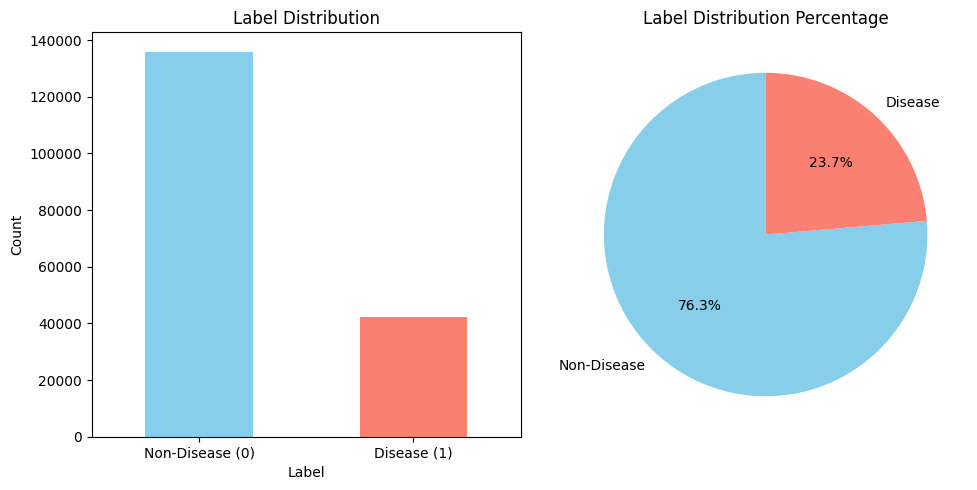

In [6]:
# Create labels
df['label'] = df['cleaned_text'].apply(lambda x: contains_disease_keywords(x, disease_keywords))

# Check label distribution
print("\nLabel Distribution:")
label_counts = df['label'].value_counts()
print(label_counts)
print(f"\nDisease-related tweets (1): {label_counts[1]:,} ({label_counts[1]/len(df)*100:.2f}%)")
print(f"Non-disease tweets (0): {label_counts[0]:,} ({label_counts[0]/len(df)*100:.2f}%)")

# Visualize label distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.xticks([0, 1], ['Non-Disease (0)', 'Disease (1)'], rotation=0)

plt.subplot(1, 2, 2)
plt.pie(label_counts.values, labels=['Non-Disease', 'Disease'],
        autopct='%1.1f%%', colors=['skyblue', 'salmon'], startangle=90)
plt.title('Label Distribution Percentage')
plt.tight_layout()
plt.show()

## Step 7: BERT Tokenization

In [7]:
# Load pre-trained BERT tokenizer
print("Loading BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("Tokenizer loaded successfully!")

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizer loaded successfully!


In [8]:
# Test tokenization on a sample tweet
sample_text = df['cleaned_text'].iloc[0]
print(f"Original text: {sample_text}\n")

# Tokenize
encoded = tokenizer.encode_plus(
    sample_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

print(f"Input IDs shape: {encoded['input_ids'].shape}")
print(f"Attention mask shape: {encoded['attention_mask'].shape}")
print(f"\nFirst 20 tokens: {tokenizer.convert_ids_to_tokens(encoded['input_ids'][0])[:20]}")

Original text: smelled scent hand sanitizers today someone past would think intoxicated

Input IDs shape: torch.Size([1, 128])
Attention mask shape: torch.Size([1, 128])

First 20 tokens: ['[CLS]', 'smelled', 'scent', 'hand', 'san', '##iti', '##zers', 'today', 'someone', 'past', 'would', 'think', 'into', '##xi', '##cated', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [13]:
MAX_LEN = 128
SAMPLE_SIZE = 10000

# Sample the dataset
df_sample = df.head(SAMPLE_SIZE).copy()

input_ids = []
attention_masks = []

for text in df_sample['cleaned_text']:
    encoded = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

# Convert to tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df_sample['label'].values)

print(f"\nTokenization complete!")
print(f"Input IDs shape: {input_ids.shape}")
print(f"Attention masks shape: {attention_masks.shape}")
print(f"Labels shape: {labels.shape}")


Tokenization complete!
Input IDs shape: torch.Size([10000, 128])
Attention masks shape: torch.Size([10000, 128])
Labels shape: torch.Size([10000])


## Step 8: Get BERT Embeddings

In [14]:
# Load pre-trained BERT model
print("Loading BERT model...")
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model = bert_model.to(device)
bert_model.eval()  # Set to evaluation mode
print("BERT model loaded successfully!")

Loading BERT model...
BERT model loaded successfully!


In [15]:
def get_bert_embeddings(input_ids, attention_masks, batch_size=32):
    """
    Extract BERT embeddings from [CLS] token
    """
    embeddings = []

    # Create DataLoader for batch processing
    dataset = TensorDataset(input_ids, attention_masks)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    print(f"Extracting embeddings in batches of {batch_size}...")

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            batch_input_ids = batch[0].to(device)
            batch_attention_masks = batch[1].to(device)

            # Get BERT outputs
            outputs = bert_model(
                input_ids=batch_input_ids,
                attention_mask=batch_attention_masks
            )

            # Extract [CLS] token embeddings (first token)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embeddings.cpu().numpy())

            if (batch_idx + 1) % 50 == 0:
                print(f"Processed {(batch_idx + 1) * batch_size} tweets...")

    return np.vstack(embeddings)

# Extract embeddings
embeddings = get_bert_embeddings(input_ids, attention_masks, batch_size=32)

print(f"\nEmbeddings extracted successfully!")
print(f"Embeddings shape: {embeddings.shape}")
print(f"Each tweet is represented by {embeddings.shape[1]} dimensions")

Extracting embeddings in batches of 32...
Processed 1600 tweets...
Processed 3200 tweets...
Processed 4800 tweets...
Processed 6400 tweets...
Processed 8000 tweets...
Processed 9600 tweets...

Embeddings extracted successfully!
Embeddings shape: (10000, 768)
Each tweet is represented by 768 dimensions


In [16]:
# Save embeddings for later use
np.save('bert_embeddings.npy', embeddings)
print("Embeddings saved to bert_embeddings.npy")

Embeddings saved to bert_embeddings.npy


## Step 9: Train Disease Detection Classifier

In [17]:
# Split data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    embeddings,
    df_sample['label'].values,
    test_size=0.2,
    random_state=42,
    stratify=df_sample['label'].values
)

print("Data split completed:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set label distribution:")
print(pd.Series(y_train).value_counts())
print(f"\nTest set label distribution:")
print(pd.Series(y_test).value_counts())

Data split completed:
Training set: 8000 samples
Test set: 2000 samples

Training set label distribution:
1    6109
0    1891
Name: count, dtype: int64

Test set label distribution:
1    1527
0     473
Name: count, dtype: int64


### Train Random Forest Classifier

In [18]:
# Train Random Forest classifier
print("Training Random Forest classifier...")
rf_classifier = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_classifier.fit(X_train, y_train)
print("\nTraining complete!")

Training Random Forest classifier...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.6s



Training complete!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.2s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished



RANDOM FOREST CLASSIFIER RESULTS

Accuracy:  0.8120
Precision: 0.8089
Recall:    0.9869
F1-Score:  0.8891

Classification Report:
              precision    recall  f1-score   support

 Non-Disease       0.85      0.25      0.38       473
     Disease       0.81      0.99      0.89      1527

    accuracy                           0.81      2000
   macro avg       0.83      0.62      0.64      2000
weighted avg       0.82      0.81      0.77      2000



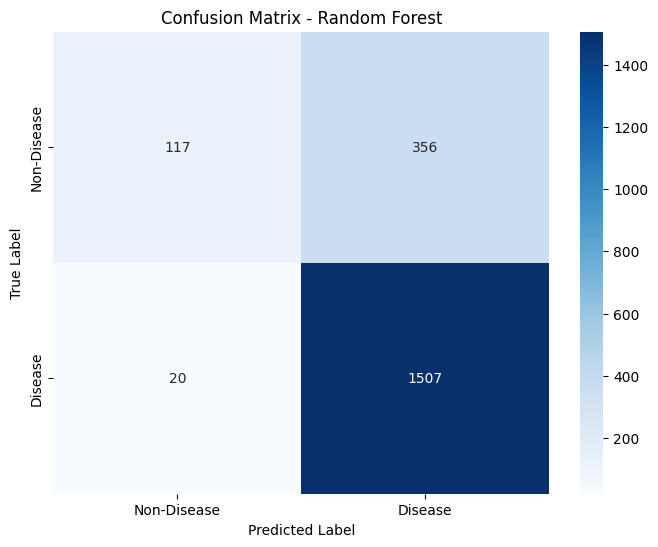

In [19]:
# Make predictions
y_pred_rf = rf_classifier.predict(X_test)

# Calculate metrics
print("\n" + "="*60)
print("RANDOM FOREST CLASSIFIER RESULTS")
print("="*60)

accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Non-Disease', 'Disease']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Disease', 'Disease'],
            yticklabels=['Non-Disease', 'Disease'])
plt.title('Confusion Matrix - Random Forest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Train Logistic Regression Classifier

In [20]:
# Train Logistic Regression classifier
print("Training Logistic Regression classifier...")
lr_classifier = LogisticRegression(
    max_iter=1000,
    random_state=42,
    verbose=1
)

lr_classifier.fit(X_train, y_train)
print("\nTraining complete!")

Training Logistic Regression classifier...

Training complete!


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished



LOGISTIC REGRESSION CLASSIFIER RESULTS

Accuracy:  0.8780
Precision: 0.9115
Recall:    0.9306
F1-Score:  0.9209

Classification Report:
              precision    recall  f1-score   support

 Non-Disease       0.76      0.71      0.73       473
     Disease       0.91      0.93      0.92      1527

    accuracy                           0.88      2000
   macro avg       0.84      0.82      0.83      2000
weighted avg       0.88      0.88      0.88      2000



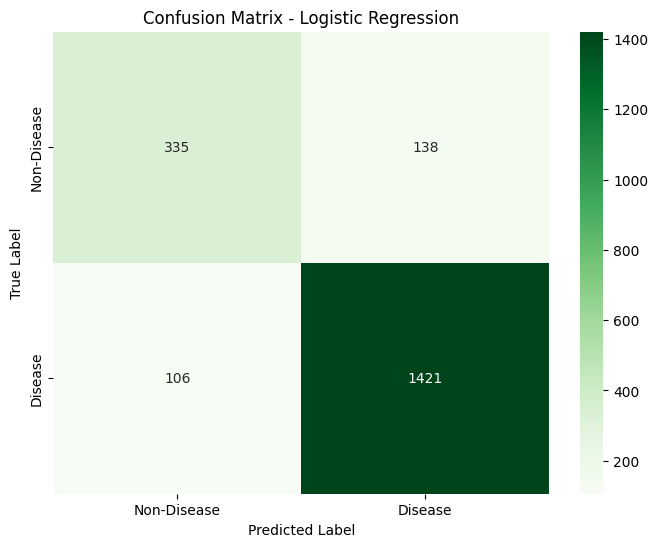

In [21]:
# Make predictions
y_pred_lr = lr_classifier.predict(X_test)

# Calculate metrics
print("\n" + "="*60)
print("LOGISTIC REGRESSION CLASSIFIER RESULTS")
print("="*60)

accuracy = accuracy_score(y_test, y_pred_lr)
precision = precision_score(y_test, y_pred_lr)
recall = recall_score(y_test, y_pred_lr)
f1 = f1_score(y_test, y_pred_lr)

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, target_names=['Non-Disease', 'Disease']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Disease', 'Disease'],
            yticklabels=['Non-Disease', 'Disease'])
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Save Best Model

In [22]:
# Save both models
with open('rf_classifier.pkl', 'wb') as f:
    pickle.dump(rf_classifier, f)

with open('lr_classifier.pkl', 'wb') as f:
    pickle.dump(lr_classifier, f)

print("Models saved successfully!")
print("- Random Forest: ../data/models/rf_classifier.pkl")
print("- Logistic Regression: ../data/models/lr_classifier.pkl")

Models saved successfully!
- Random Forest: ../data/models/rf_classifier.pkl
- Logistic Regression: ../data/models/lr_classifier.pkl


## Step 10: Semantic Similarity Setup

In [23]:
# Define reference disease-related sentences
reference_sentences = [
    "I have fever and cough symptoms",
    "Tested positive for COVID-19",
    "Feeling sick with body aches",
    "Lost sense of taste and smell",
    "Having trouble breathing and chest pain",
    "Experiencing fatigue and headache",
    "Got diagnosed with coronavirus",
    "Hospital admission due to severe symptoms"
]

print("Reference disease-related sentences:")
for i, sentence in enumerate(reference_sentences, 1):
    print(f"{i}. {sentence}")

Reference disease-related sentences:
1. I have fever and cough symptoms
2. Tested positive for COVID-19
3. Feeling sick with body aches
4. Lost sense of taste and smell
5. Having trouble breathing and chest pain
6. Experiencing fatigue and headache
7. Got diagnosed with coronavirus
8. Hospital admission due to severe symptoms


In [24]:
# Get embeddings for reference sentences
print("\nGenerating embeddings for reference sentences...")

reference_input_ids = []
reference_attention_masks = []

for sentence in reference_sentences:
    encoded = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    reference_input_ids.append(encoded['input_ids'])
    reference_attention_masks.append(encoded['attention_mask'])

reference_input_ids = torch.cat(reference_input_ids, dim=0)
reference_attention_masks = torch.cat(reference_attention_masks, dim=0)

# Get embeddings
reference_embeddings = get_bert_embeddings(reference_input_ids, reference_attention_masks, batch_size=8)

print(f"Reference embeddings shape: {reference_embeddings.shape}")


Generating embeddings for reference sentences...
Extracting embeddings in batches of 8...
Reference embeddings shape: (8, 768)


In [25]:
def calculate_similarity(tweet_embedding, reference_embeddings):
    """
    Calculate cosine similarity between tweet and reference sentences
    Returns the maximum similarity score
    """
    similarities = cosine_similarity(tweet_embedding.reshape(1, -1), reference_embeddings)
    return np.max(similarities)

# Test similarity on sample tweets
print("\nTesting semantic similarity on sample tweets:")
print("="*80)

for i in range(5):
    tweet_text = df_sample['cleaned_text'].iloc[i]
    tweet_embedding = embeddings[i]
    similarity = calculate_similarity(tweet_embedding, reference_embeddings)

    print(f"\nTweet: {tweet_text[:100]}...")
    print(f"Similarity Score: {similarity:.4f}")
    print(f"Disease-related: {'YES' if similarity > 0.7 else 'NO'}")
    print("-"*80)


Testing semantic similarity on sample tweets:

Tweet: smelled scent hand sanitizers today someone past would think intoxicated...
Similarity Score: 0.8681
Disease-related: YES
--------------------------------------------------------------------------------

Tweet: hey wouldnt made sense players pay respects...
Similarity Score: 0.8297
Disease-related: YES
--------------------------------------------------------------------------------

Tweet: trump never claimed covid hoax claim effort...
Similarity Score: 0.8326
Disease-related: YES
--------------------------------------------------------------------------------

Tweet: one gift covid give appreciation simple things always around...
Similarity Score: 0.8244
Disease-related: YES
--------------------------------------------------------------------------------

Tweet: july media bulletin novel coronavirusupdates covid...
Similarity Score: 0.7926
Disease-related: YES
-----------------------------------------------------------------------

Calculating similarities for all tweets...


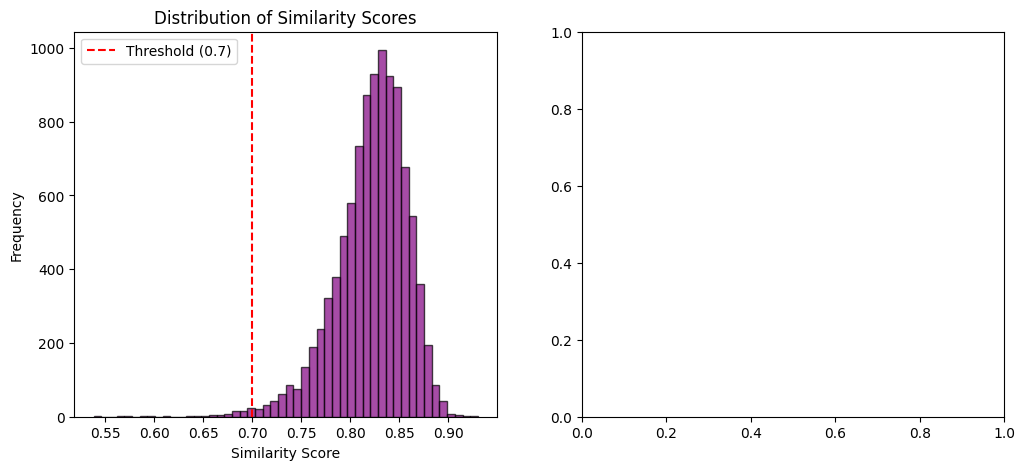

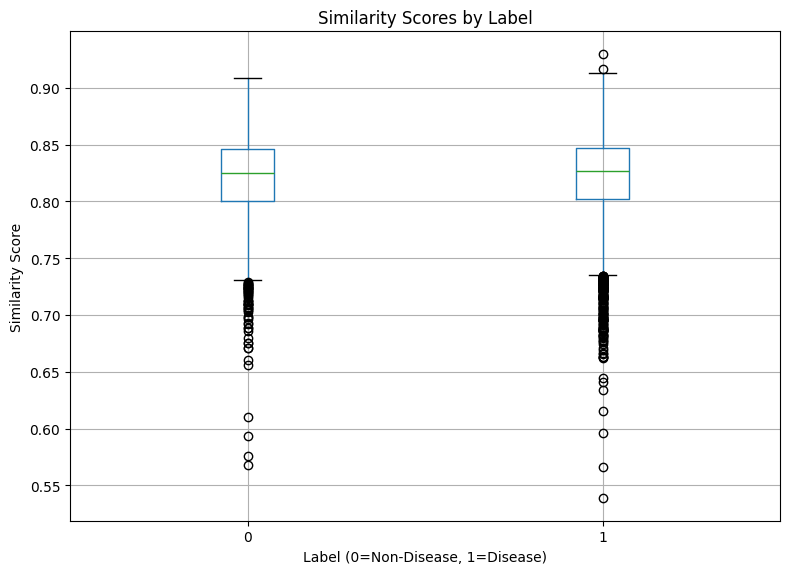


Similarity Statistics:
count    10000.000000
mean         0.821392
std          0.036583
min          0.538395
25%          0.801702
50%          0.826055
75%          0.846855
max          0.930188
Name: similarity_score, dtype: float64


In [26]:
# Calculate similarities for all tweets in sample
print("Calculating similarities for all tweets...")
similarities = [calculate_similarity(emb, reference_embeddings) for emb in embeddings]

df_sample['similarity_score'] = similarities

# Visualize similarity distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_sample['similarity_score'], bins=50, edgecolor='black', alpha=0.7, color='purple')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.axvline(x=0.7, color='red', linestyle='--', label='Threshold (0.7)')
plt.legend()

plt.subplot(1, 2, 2)
df_sample.boxplot(column='similarity_score', by='label', figsize=(8, 6))
plt.xlabel('Label (0=Non-Disease, 1=Disease)')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores by Label')
plt.suptitle('')
plt.tight_layout()
plt.show()

print(f"\nSimilarity Statistics:")
print(df_sample['similarity_score'].describe())

## Step 11: Symptom Extraction

In [27]:
# Create comprehensive symptom dictionary
symptom_categories = {
    'Fever': ['fever', 'temperature', 'hot', 'burning', 'chills', 'shivering'],
    'Respiratory': ['cough', 'breathing', 'breathless', 'shortness of breath', 'chest pain', 'pneumonia', 'respiratory'],
    'Fatigue': ['tired', 'fatigue', 'exhausted', 'weak', 'weakness', 'energy'],
    'Loss of Senses': ['loss of taste', 'loss of smell', 'smell', 'taste', 'anosmia'],
    'Body Pain': ['body aches', 'muscle pain', 'joint pain', 'ache', 'pain', 'sore'],
    'Throat': ['sore throat', 'throat pain', 'throat', 'swallowing'],
    'Headache': ['headache', 'head pain', 'migraine'],
    'Gastrointestinal': ['nausea', 'vomiting', 'diarrhea', 'stomach', 'digestive'],
    'Other': ['dizzy', 'rash', 'congestion', 'runny nose', 'sneezing']
}

print("Symptom Categories:")
for category, symptoms in symptom_categories.items():
    print(f"\n{category}: {symptoms}")

Symptom Categories:

Fever: ['fever', 'temperature', 'hot', 'burning', 'chills', 'shivering']

Respiratory: ['cough', 'breathing', 'breathless', 'shortness of breath', 'chest pain', 'pneumonia', 'respiratory']

Fatigue: ['tired', 'fatigue', 'exhausted', 'weak', 'weakness', 'energy']

Loss of Senses: ['loss of taste', 'loss of smell', 'smell', 'taste', 'anosmia']

Body Pain: ['body aches', 'muscle pain', 'joint pain', 'ache', 'pain', 'sore']

Throat: ['sore throat', 'throat pain', 'throat', 'swallowing']

Headache: ['headache', 'head pain', 'migraine']

Gastrointestinal: ['nausea', 'vomiting', 'diarrhea', 'stomach', 'digestive']

Other: ['dizzy', 'rash', 'congestion', 'runny nose', 'sneezing']


In [28]:
def extract_symptoms(text, symptom_dict):
    """
    Extract symptoms from text based on symptom dictionary
    Returns a dictionary of found symptoms by category
    """
    text = str(text).lower()
    found_symptoms = {}

    for category, symptoms in symptom_dict.items():
        found = []
        for symptom in symptoms:
            if symptom in text:
                found.append(symptom)

        if found:
            found_symptoms[category] = found

    return found_symptoms

# Test symptom extraction
print("\nTesting symptom extraction on sample tweets:")
print("="*80)

for i in range(10):
    tweet = df_sample['original_text'].iloc[i]
    symptoms = extract_symptoms(tweet, symptom_categories)

    if symptoms:  # Only show tweets with symptoms
        print(f"\nTweet: {tweet[:150]}...")
        print(f"Extracted Symptoms:")
        for category, symptom_list in symptoms.items():
            print(f"  - {category}: {', '.join(symptom_list)}")
        print("-"*80)


Testing symptom extraction on sample tweets:

Tweet: If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0...
Extracted Symptoms:
  - Loss of Senses: smell
--------------------------------------------------------------------------------


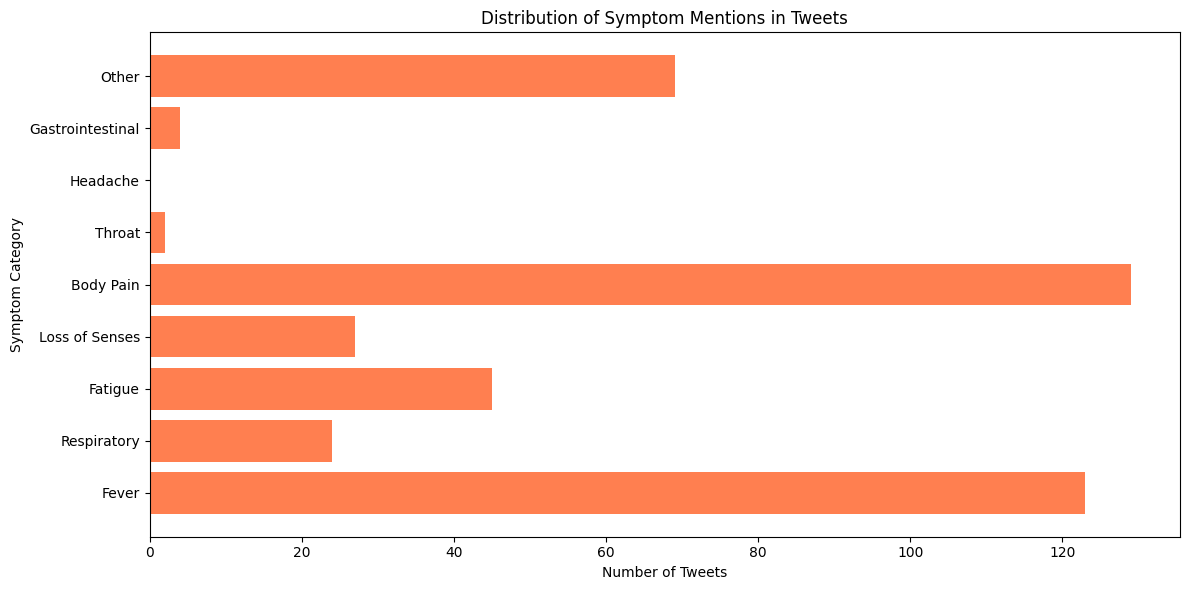


Symptom Mention Counts:
Body Pain: 129 tweets
Fever: 123 tweets
Other: 69 tweets
Fatigue: 45 tweets
Loss of Senses: 27 tweets
Respiratory: 24 tweets
Gastrointestinal: 4 tweets
Throat: 2 tweets
Headache: 0 tweets


In [29]:
# Extract symptoms for all tweets
df_sample['extracted_symptoms'] = df_sample['original_text'].apply(
    lambda x: extract_symptoms(x, symptom_categories)
)

# Count symptom mentions by category
symptom_counts = {category: 0 for category in symptom_categories.keys()}

for symptoms_dict in df_sample['extracted_symptoms']:
    for category in symptoms_dict.keys():
        symptom_counts[category] += 1

# Visualize symptom distribution
plt.figure(figsize=(12, 6))
categories = list(symptom_counts.keys())
counts = list(symptom_counts.values())

plt.barh(categories, counts, color='coral')
plt.xlabel('Number of Tweets')
plt.ylabel('Symptom Category')
plt.title('Distribution of Symptom Mentions in Tweets')
plt.tight_layout()
plt.show()

print("\nSymptom Mention Counts:")
for category, count in sorted(symptom_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{category}: {count} tweets")

## Save Processed Data with Predictions

In [30]:
# Add predictions to dataframe
df_sample['rf_prediction'] = 0
df_sample['lr_prediction'] = 0

# Add predictions for test indices
test_indices = df_sample.iloc[len(X_train):].index
df_sample.loc[test_indices, 'rf_prediction'] = y_pred_rf
df_sample.loc[test_indices, 'lr_prediction'] = y_pred_lr

# Save enhanced dataset
df_sample.to_csv('covid19_tweets_with_predictions.csv', index=False)
print("Enhanced dataset saved to '../data/processed/covid19_tweets_with_predictions.csv'")

Enhanced dataset saved to '../data/processed/covid19_tweets_with_predictions.csv'
